# Feature Engineering

#### Imports

In [28]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import PolynomialFeatures

### Model Harness

In [20]:
class ModelHistory:
    
    def __init__(self, scorer, random_state=2021):
        self.scorer = scorer
        self.history = pd.DataFrame(columns=['Name', 'Error', 'Notes'])

    def report(self, model, X, y, name, notes='', cv=5,):
        kf = KFold(n_splits=cv, random_state=2021, shuffle=True)
        scores = cross_val_score(model, X, y, 
                                 scoring=self.scorer, cv=kf)
        self.log_report(name, scores.mean(), notes)
        print('Average Score:', scores.mean())
        return scores
    
    def log_report(self, name, av_score, notes):
        frame = pd.DataFrame([[name, av_score, notes]], columns=['Name', 'Error', 'Notes'])
        self.history = self.history.append(frame)
        self.history = self.history.reset_index(drop=True)
        self.history = self.history.sort_values('Error')

    def print_error(self, name, error):
        print('{} has an average error of ${:.2f}'.format(name, error))

### Set up your modeling metric

In [21]:
def rmse_score(y_true, y_hat):
    mse = mean_squared_error(y_true, y_hat)

    return np.sqrt(mse)

rmse = make_scorer(rmse_score)

### Import data

In [22]:
raw = pd.read_csv('data/house_sale_data.csv')

In [23]:
raw.head()

,sale_id,day,month,sale_price,n_bedrooms,n_bathrooms,finished_sqft,lot_size_sqft,n_floors,waterfront_indicator,view_index,condition_index,construction_grade_index,finished_above_ground_sqft,finished_below_ground_sqft,year_built,year_renovated,zipcode,latitude,longitude
0,7129300520,13,10,221900,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,54968,47.5112,-92.873
1,6414100192,9,12,538000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,54915,47.7210,-92.935
2,5631500400,25,2,180000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,54818,47.7379,-92.849
3,2487200875,9,12,604000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,54926,47.5208,-93.009
4,1954400510,18,2,510000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,54864,47.6168,-92.661


### Clean data

In [24]:
drop = ['sale_id', 'zipcode']
df = raw.drop(drop, axis = 1)

df.finished_above_ground_sqft = pd.to_numeric(df.finished_above_ground_sqft, errors='coerce')

### Train Test Split

In [25]:
X = df.drop('sale_price', axis=1)
y = df.sale_price

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2021)

# Experiments

In [26]:
history = ModelHistory(rmse)

### Baseline

In [27]:
linear_regression = LinearRegression()
history.report(linear_regression,X_train, y_train, 'Linear Regression - Defaults')

Average Score: 203667.06564269523


array([204278.21712003, 205532.48511261, 194535.45106361, 210175.20070111,
       203813.97421612])

### Polynomials

In [29]:
interactor = PolynomialFeatures(interaction_only=True)
X_train_interactions = interactor.fit_transform(X_train)

history.report(linear_regression, X_train_interactions, y_train,
               'Linear Regression', 'Added interaction terms')

Average Score: 174428.1402286037


array([181549.90473385, 165574.42572078, 171075.70598882, 172255.93215438,
       181684.73254519])

## Bathrooms

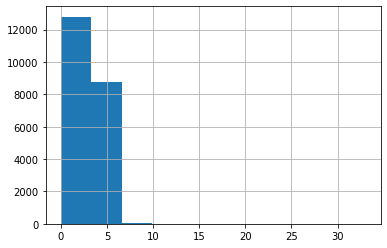

In [33]:
X.n_bedrooms.hist()

#### Greater than 5 indicator

In [37]:
bedrooms = X_train.copy()

In [39]:
def bin_bedrooms_greater_than_five(x):
    if x > 5:
        return 1
    else:
        return 0
    
bedrooms['greater_than_5_bedrooms'] = bedrooms.n_bedrooms.apply(bin_bedrooms_greater_than_five)

In [40]:
history.report(linear_regression, bedrooms, y_train,
               'Linear Regression', '''Added greater than 5 bedrooms indicator
                                       did not drop n_bedrooms.''') 

Average Score: 203720.2591765356


array([204289.21467182, 205568.11705689, 194685.73744918, 210146.109721  ,
       203912.11698379])

In [41]:
history.history

,Name,Error,Notes
0,Linear Regression,174428.140229,Added interaction terms
1,Linear Regression - Defaults,203667.065643,
2,Linear Regression,203720.259177,Added greater than 5 bedrooms indicator\n ...


In [42]:
raw

,sale_id,day,month,sale_price,n_bedrooms,n_bathrooms,finished_sqft,lot_size_sqft,n_floors,waterfront_indicator,view_index,condition_index,construction_grade_index,finished_above_ground_sqft,finished_below_ground_sqft,year_built,year_renovated,zipcode,latitude,longitude
0,7129300520,13,10,221900,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,54968,47.5112,-92.873
1,6414100192,9,12,538000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,54915,47.7210,-92.935
2,5631500400,25,2,180000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,54818,47.7379,-92.849
3,2487200875,9,12,604000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,54926,47.5208,-93.009
4,1954400510,18,2,510000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,54864,47.6168,-92.661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,21,5,360000,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,54893,47.6993,-92.962
21609,6600060120,23,2,400000,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,54936,47.5107,-92.978
21610,1523300141,23,6,402101,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,54934,47.5944,-92.915
21611,291310100,16,1,400000,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,54817,47.5345,-92.685


In [ ]:
exponents = range(2,100)

corr = 0
best_e = 1
for e in exponents:
    
    trans = X_train.construction_grade_index ** e

    new_corr = pd.DataFrame(np.array([trans.values, y_train.values]).T, 
                 columns = ['construction_grade**5', 'sale_price']).corr().sale_price[0]
    new_corr = round(new_corr, 3)
    if new_corr > corr:
        corr = new_corr
        best_e = e

        
        
print('Best exponent:', best_e)
print('Correlation:', corr)
sns.regplot(x=X_train.construction_grade_index ** best_e, y=y_train)
plt.title(f'Construction Grade**{best_e} vs. Sale Price');